# Shallow Neural Networks [\[shallow-neural-networks\]](https://www.geeksforgeeks.org/deep-learning/shallow-neural-networks/)<br>

### COMPONENTS
- _input layer_ --> network receives input data. each neuron is a feature of the input dataset
- _hidden layer_ (ONLY ONE) --> neurons apply a set of weights to the inputs and pass them through the activation function to introduce non-linearity to the process.
- _output layer_ --> network produces output of the network. 
### FUNCTIONALITIES
- _weighted sum_ --> each neuron in the hidden layer calculates weighted sums of the inputs
- _activation function_ --> to introduce non linearity
- _output generation_ --> output layer integrates signals from hidden layer through another set of weights to produce final output
### INVOLVED IN THE TRAINING
- _forward propagation_ --> calculating the output for a given input by passing it through the layers of the network
- _loss calculation_ --> determining how far the network's output is from the actual desired output using a loss function
- _backpropagation_ --> calculating the gradient of the loss function with respect to each weight in the network, which informs how the weights should be adjusted to minimize the loss
- _weight update_ --> adjusting the weights using an optimization algorithm like gradient descent

**! LOCAL MODEL** = una rete per ogni time serie (per ora faccio questo) <br>
**GLOBAL MODEL** = una rete unica: se ho serie simili (PIL di 10 paesi diversi) posso mettere dati insieme e rete impara modello generale di crescita economica

## MULTI LAYER PERCEPTRON (MLP) [\[MLP-machinelearningmastery\]](https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/)

1. [import + upload + preprocessing](#upload)
2. [data augmentation](#augm)
3. [scaling](#scaling)
4. [sliding window](#sliding-window)
5. [definition and training of NN](#training)
6. [future predictions with recursive prediction](#predictions) = per predirre 2027 uso reale2022-reale2023-reale2024-_predizione2025_

<a id="upload"></a>
## Import + upload + preprocessing

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# plot styles
colors = ['#1f77b4', '#ff7f0e', '#d62728',  '#2ca02c']

# UNUSABLE = [
#     "Rural population living in areas where elevation is below 5 meters (% of total population)",
#     "Access to electricity, rural (% of rural population)",
#     "Surface area (sq. km)",
#     "Rural land area (sq. km)",
#     "Land area (sq. km)",
#     "Average precipitation in depth (mm per year)",
#     "Agricultural irrigated land (% of total agricultural land)",
#     "Rural land area where elevation is below 5 meters (% of total land area)",
#     "Rural land area where elevation is below 5 meters (sq. km)"
# ]

In [73]:
df = pd.read_excel('./italy_values_dataset.xlsx')

In [74]:
target = (
    df[df["Indicator Name"] == 'Rural population (% of total population)']
    .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
    .assign(Year=lambda d: d["Year"].astype(int))
    .dropna(subset=["Value"])
    [["Year", "Value"]]
    .reset_index(drop=True)
)

#### Divisione in train e test set

In [75]:
split_idx = int(len(target)*0.8)
x_train = target['Year'].iloc[:split_idx]
y_train = target['Value'].iloc[:split_idx]
y_test = target.iloc[split_idx:]

<a class="anchor" id="augm"></a>
## Data augmentation

[Time Series Data Augmentation for Deep Learning: A Survey](https://arxiv.org/abs/2002.12478)

Noise injection is a method by injecting small amount
of noise/outlier into time series without changing the corresponding labels. This includes injecting Gaussian noise,
spike, step-like trend, and slope-like trend, etc.

[Time series forecasting using a hybrid ARIMA and neural network model](https://www.sciencedirect.com/science/article/pii/S0925231201007020)
Although ARIMA models are quite flexible in that they can represent several different types of time series, i.e., pure autoregressive (AR), pure moving average (MA) and combined AR and MA (ARMA) series, their major limitation is the pre-assumed linear form of the model. That is, a linear correlation structure is assumed among the time series values and therefore, no nonlinear patterns can be captured by the ARIMA model. 

Many empirical studies including several large-scale forecasting competitions suggest that by combining several different models, forecasting accuracy can often be improved over the individual model without the need to find the “true” or “best” model

In [76]:
def augment_step_function(x, y, scale_factor):
    """
    Augments data points of initial time serie by scale_factor times

    Args:
        x (_type_): first sequence to be interpolated ['Year']
        y (_type_): second sequence to be interpolated ['Value']
        scale_factor (int): by how many points the time serie have to be augmented

    Returns:
        DataFrame{'Year', 'Value'}: df with columns of Year and Value interpolated by scale_factor
    """
    
    # 'kind=previous' mantiene il valore precedente (comportamento a gradino)
    f = interp1d(x, y, kind='previous', fill_value="extrapolate")
    x_step = np.linspace(x.min(), x.max(), len(x) * scale_factor)
    y_step = f(x_step)
    return pd.DataFrame({'Year': x_step, 'Value': y_step})

In [77]:
def augment_linear_with_jitter(x, y, scale_factor, noise_level):
    """
    Creates new data points by interpolation = tracing a line between existing data points
    and adds jittering = casual noise for resilience

    Args:
        x (_type_): first sequence to be interpolated ['Year']
        y (_type_): second sequence to be interpolated ['Value']
        scale_factor (int): by how many points the time serie have to be augmented
        noise_level (float): standard deviation of noise (0.01 = 1% variation)

    Returns:
        DataFrame{'Year', 'Value'}: df with columns of Year and Value interpolated by scale_factor
    """
    f = interp1d(x, y, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(x.min(), x.max(), len(x) * scale_factor)
    y_interp = f(x_interp)
    
    noise = np.random.normal(loc=0.0, scale=noise_level, size=y_interp.shape)
    y_new = y_interp + noise
    return pd.DataFrame({'Year': x_interp, 'Value': y_new})

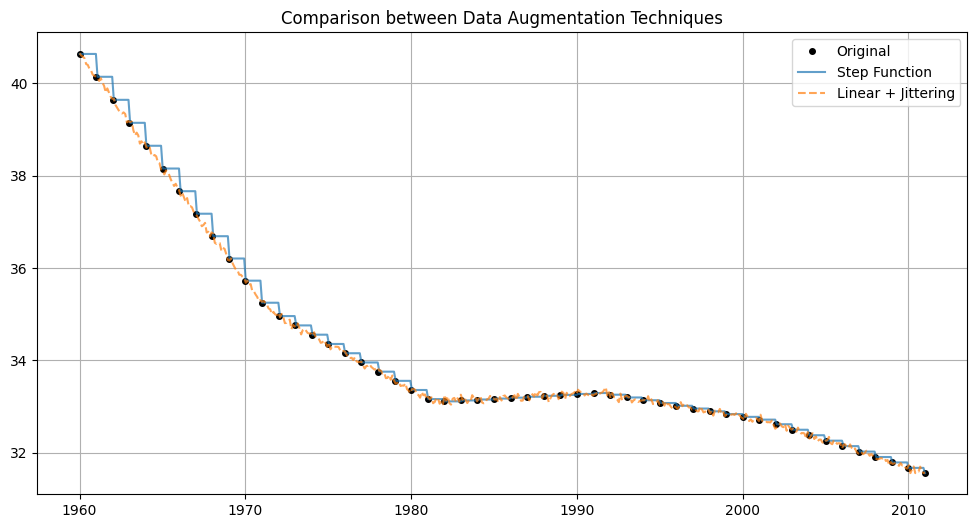

In [78]:
df_step = augment_step_function(x_train, y_train, scale_factor=10)
df_jitter = augment_linear_with_jitter(x_train, y_train, scale_factor=10, noise_level=0.05)
df_step_u = df_step.drop_duplicates(subset='Year')
df_jitter_u = df_jitter.drop_duplicates(subset='Year')

plt.figure(figsize=(12, 6))
plt.plot(x_train, y_train, '.', label='Original', color='black', markersize=8)
plt.plot(df_step['Year'], df_step['Value'], '-', label='Step Function', alpha=0.7)
plt.plot(df_jitter['Year'], df_jitter['Value'], '--', label='Linear + Jittering', alpha=0.7)
plt.title("Comparison between Data Augmentation Techniques")
plt.legend()
plt.grid(True)
plt.show()

<a class="anchor" id="scaling"></a>
## Scaling

In [79]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.values.reshape(-1, 1))

train_norm_orig = scaler.transform(y_train.values.reshape(-1, 1))
train_norm_step = scaler.transform(df_step['Value'].values.reshape(-1, 1))
train_norm_jitter = scaler.transform(df_jitter['Value'].values.reshape(-1, 1))

test_norm = scaler.transform(y_test.values.reshape(-1, 1))

# display(train_norm_orig)
# display(train_norm_step)
# display(train_norm_jitter)

<a class="anchor" id="sliding-window"> </a>
## Sliding window

In [80]:
def create_sliding_window(data, window_size, HORIZON):
    """
    Transforms a univariate time series into a supervised dataset (X, y)

    Parametri:
    - data (np.array): Array NumPy 1D contenente la serie temporale scalata.
    - window_size (int): Numero di step temporali passati da usare come input (X).
    - HORIZON (int): Distanza nel futuro del target da predire (default=1, cioè lo step successivo).

    Ritorna:
    - X (np.array): Matrice delle features di input (campioni, window_size).
    - y (np.array): Array dei target (campioni).
    """
    X, y = [], []
    
    # Iteriamo attraverso la serie fino a quando c'è abbastanza spazio per la finestra + target
    for i in range(len(data) - window_size - HORIZON + 1):
        # Estraiamo la finestra di input (dal punto i al punto i + window_size)
        seq = data[i:(i + window_size), 0]
        
        # Estraiamo il target (il punto esattamente dopo la finestra, o più avanti se HORIZON > 1)
        target = data[i + window_size + HORIZON - 1, 0]
        
        X.append(seq)
        y.append(target)
        
    return np.array(X), np.array(y)

In [82]:
window_size = 3
HORIZON = 1
X_train, y_train = create_sliding_window(train_norm_orig, window_size, HORIZON)
X_train_step, y_train_step = create_sliding_window(train_norm_step, window_size, HORIZON)
X_train_jitter, y_train_jitter = create_sliding_window(train_norm_jitter, window_size, HORIZON)

X_test, y_test = create_sliding_window(test_norm, window_size, HORIZON)
display(X_train[:3], y_train[:2])
display(X_test[:3], y_test[:2])

array([[1.        , 0.94550259, 0.89056479],
       [0.94550259, 0.89056479, 0.83573709],
       [0.89056479, 0.83573709, 0.78101949]])

array([0.83573709, 0.78101949])

array([[ 2.18038534e+02, -2.64229880e-02,  2.18148629e+02],
       [-2.64229880e-02,  2.18148629e+02, -5.89012441e-02],
       [ 2.18148629e+02, -5.89012441e-02,  2.18258725e+02]])

array([-5.89012441e-02,  2.18258725e+02])

<a class="anchor" id="training"> </a>
## Definition and training of an MLP shallow neural network 

In [84]:
def build_mlp_model(input_dim):
    model = Sequential()
    # Input Layer esplicito (Best Practice moderna)
    model.add(Input(shape=(input_dim,))) 
    # Hidden Layer
    model.add(Dense(24, activation='relu'))
    # Output Layer (1 neurone perché prediciamo 1 valore: la popolazione)
    model.add(Dense(1)) 
    
    model.compile(optimizer='adam', loss='mse')##
    return model

In [85]:
import matplotlib.pyplot as plt

# 1. Organizziamo i dataset in un dizionario per iterare comodamente
datasets_experiment = {
    "Original (Small)": (X_train, y_train),
    "Augmented (Step)": (X_train_step, y_train_step),
    "Augmented (Jitter)": (X_train_jitter, y_train_jitter)
}

results = {}
histories = {}

# 2. Ciclo di Training
print("--- INIZIO TRAINING ---")

for name, (train_x, train_y) in datasets_experiment.items():
    print(f"\nTraining sul dataset: {name} ...")
    
    # A. Costruiamo un modello vergine
    # input_dim = window_size (es. 3)
    model = build_mlp_model(input_dim=train_x.shape[1])
    
    # B. Alleniamo
    # epochs=500 è buono per dataset piccoli
    history = model.fit(train_x, train_y, epochs=500, verbose=0, batch_size=16)
    
    # C. Facciamo la predizione sul TEST SET (sempre lo stesso per tutti!)
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # D. Invertiamo lo scaling per tornare ai numeri reali (Popolazione %)
    y_pred_real = scaler.inverse_transform(y_pred_scaled)
    
    # Salviamo i risultati
    results[name] = y_pred_real
    histories[name] = history.history['loss']
    
print("\n--- TRAINING COMPLETATO ---")

--- INIZIO TRAINING ---

Training sul dataset: Original (Small) ...

Training sul dataset: Augmented (Step) ...

Training sul dataset: Augmented (Jitter) ...

--- TRAINING COMPLETATO ---


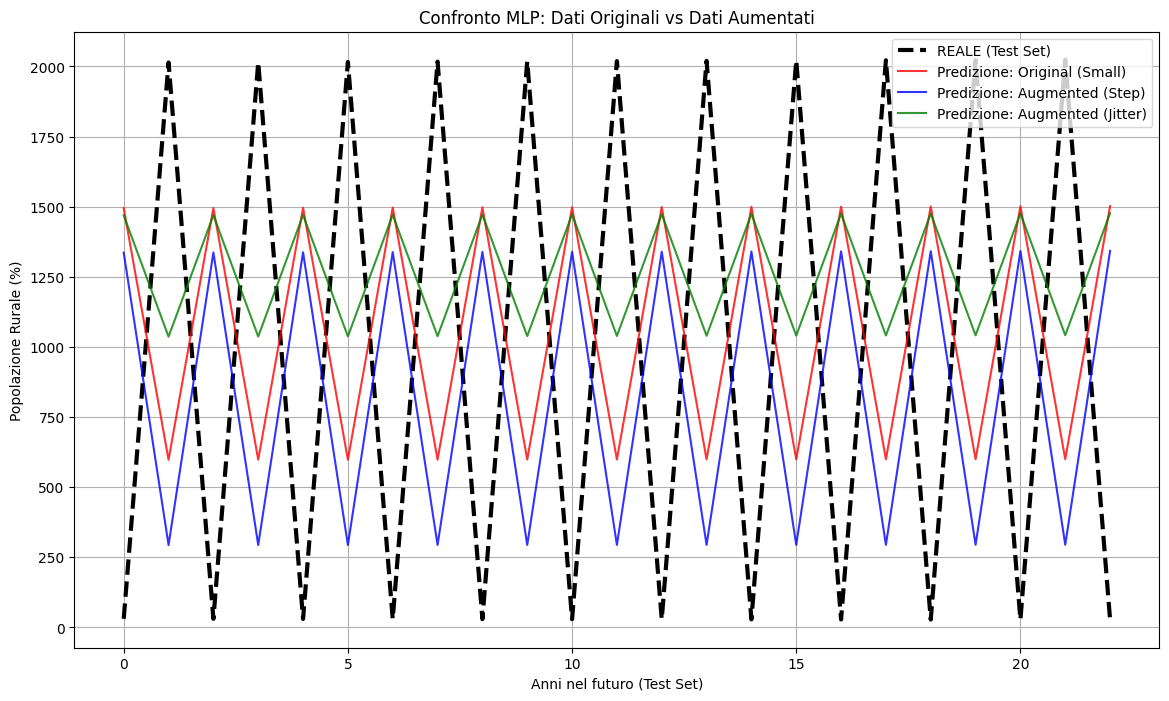

In [86]:
# Prepariamo i dati reali del test per il grafico
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 8))

# Plot dei dati reali (Target)
plt.plot(y_test_real, label='REALE (Test Set)', color='black', linewidth=3, linestyle='--')

# Plot delle predizioni dei 3 modelli
colors = ['red', 'blue', 'green']
for (name, preds), color in zip(results.items(), colors):
    plt.plot(preds, label=f'Predizione: {name}', color=color, alpha=0.8)

plt.title("Confronto MLP: Dati Originali vs Dati Aumentati")
plt.xlabel("Anni nel futuro (Test Set)")
plt.ylabel("Popolazione Rurale (%)")
plt.legend()
plt.grid(True)
plt.show()

RADIAL BASIS FUNCTION (RBF) NETWORK

EXTREME LEARNING MACHINE (ELM)